## Analyse des biens de consommation textuels



In [1]:
import pandas as pd
import numpy as np
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import nltk
nltk.download('popular')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer, LabelBinarizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import NMF,TruncatedSVD
from sklearn.cluster import KMeans

# import for classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import fonctions_text_pict as fct
from nbpep8.nbpep8 import pep8

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\leila\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\leila\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\leila\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\leila\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\leila\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

C:\Users\leila\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1 Etude des descriptions de produits

**1.1 chargement du dataset et transformation des categories**

La colonne product_category_tree va etre separee en trois colonnes , chacune correspondant a un niveau de l'arbre

In [3]:
df = pd.read_csv("C:/Users/leila/openclassrooms/projet6/flipkart_com-ecommerce_sample_1050.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
def split_categories(category, level):
    '''Create categories '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def detail_categories(data):
    '''Create a column per category level'''
    data['cat_lvl_1'] = data['product_category_tree'].apply(split_categories_1)
    data['cat_lvl_2'] = data['product_category_tree'].apply(split_categories_2)
    data['cat_lvl_3'] = data['product_category_tree'].apply(split_categories_3)
    return data.drop(['product_category_tree'], axis=1)

In [6]:
df = detail_categories(df)

In [7]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels


In [8]:
df.cat_lvl_1.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Changement des noms de categories du niveau 1 par des noms plus gmobalisant

In [9]:
df['cat_lvl_1'] = df['cat_lvl_1'].replace({'Home Furnishing' : 'Furnishing',
                                         'Baby Care' : 'Baby',
                                         'Home Decor & Festive Needs' : 'Decor',
                                         'Kitchen & Dining' :'Kitchen',
                                         'Beauty and Personal Care' : 'Beauty'})

In [10]:
# creation du data constitue de la categorie principale, du nom du produit et de sa description
data = df[['uniq_id','cat_lvl_1','product_name','description']].copy()

# pas de doublons pour 'uniq_id' donc on peut le prendre en index
data.set_index('uniq_id')

,cat_lvl_1,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...
fd6cbcc22efb6b761bd564c28928483c,Baby,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...
5912e037d12774bb73a2048f35a00009,Baby,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...


Representation de la distribution de la longueur de la chaine donnant le nom du produit

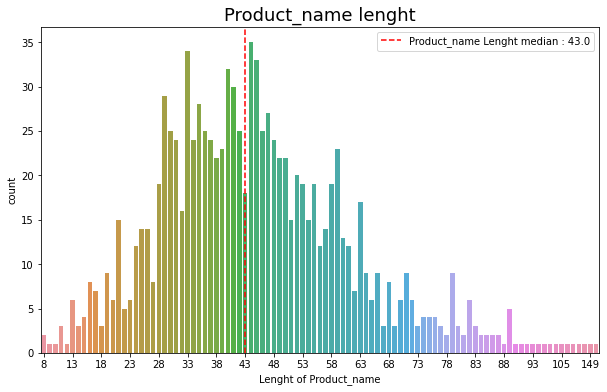

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data.product_name.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(data.product_name.str.len().median() - data.product_name.str.len().min(),
            color="r", linestyle='--',
            label="Product_name Lenght median : "+str(data.product_name.str.len().median()))
ax.set_xlabel("Lenght of Product_name")
plt.title("Product_name lenght", fontsize=18)
plt.legend()
plt.show()

On va faire de meme pour la description des produits mais en discretisant pour rendre le graphique plus lisible

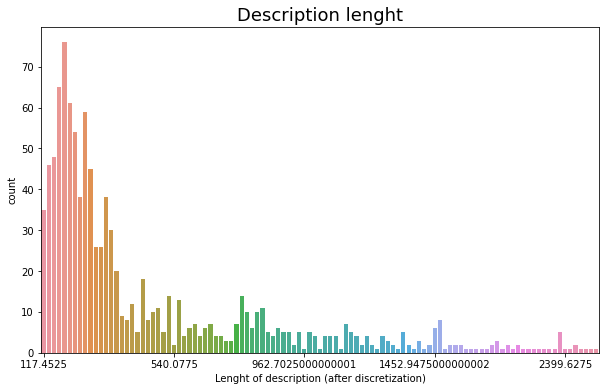

In [12]:
# Discretizer for Body characters lenght
X = pd.DataFrame(data.description.str.len())

# Sklearn discretizer with 200 bins
discretizer = KBinsDiscretizer(n_bins=200,
                               encode='ordinal',
                               strategy='uniform')
desc_lenght = discretizer.fit_transform(X)
desc_lenght = discretizer.inverse_transform(desc_lenght)
desc_lenght = pd.Series(desc_lenght.reshape(-1))

fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x=desc_lenght)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
ax.set_xlabel("Lenght of description (after discretization)")
plt.title("Description lenght", fontsize=18)

plt.show()



 **1.2 Nettoyage des textes pour les noms de produits et leur description**
 
Nous allons utiliser nltk.pos_tag pour identifier la nature de chaque mot du corpus afin de pouvoir ensuite conserver uniquement les noms. Nous allons ici créer une function qui sera appliquée ensuite dans un cleaner plus complet (tout aurait pu être réalisé avec SpaCy, mais pour l'exercice et la méthode, les autres étapes sont détaillées).

In [13]:
def remove_pos(nlp, x, pos_list):
    doc = nlp(x)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower()
    return join_text_row

Nous allons à présent réaliser plusieurs opérations de Text cleaning pour que nos données soient exploitables par les algorithmes de NLP :

- Suppression de tous les mots autres que les noms
- Mettre tout le texte en minuscules
- Supprimer les caractères Unicode 
- Suppression des espaces supplémentaires
- Suppression de la ponctuation
- Suppression des liens
- Supprimer les nombres



In [14]:
def text_cleaner(x, nlp, pos_list):
    """Function allowing to carry out the preprossessing on the textual data. 
        It allows you to remove extra spaces, unicode characters, 
        English contractions, punctuation and numbers.
        
        The re library for using regular expressions must be loaded beforehand.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    # Remove POS not in "NOUN", "PROPN"
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation
    x = re.sub('[^\w\s]', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x

In [15]:
# Apply cleaner on Description
# Spacy features
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]
data['description_cleaned'] = data.description.apply(lambda x : text_cleaner(x, nlp, pos_list))

print(data['description_cleaned'].head(3))

0    key features elegance polyester multicolor abs...
1    specifications sathiyas cotton bath towel bath...
2    key features eurospa cotton terry face towel s...
Name: description_cleaned, dtype: object


Nous pouvons à présent supprimer tous les stop words en langue Anglaise grâce à la librairie NLTK. Avant cette étape, nous allons réaliser une tockenisation c'est à dire découper les phrase en mots et création d'une liste (chaque phrase est une liste de mots)

In [16]:
# Tockenization
data['description_cleaned'] = data.description_cleaned.apply(nltk.tokenize.word_tokenize)

# List of stop words in "EN" from NLTK
stop_words = stopwords.words("english")

# Remove stop words
data['description_cleaned'] = data.description_cleaned\
    .apply(lambda x : [word for word in x
                       if word not in stop_words
                       and len(word)>2])
print(data['description_cleaned'].head(3))

0    [key, features, elegance, polyester, multicolo...
1    [specifications, sathiyas, cotton, bath, towel...
2    [key, features, eurospa, cotton, terry, face, ...
Name: description_cleaned, dtype: object


A présent, nous avons des listes de mots débarrassées des mots courants (stop words), de la ponctuation, des liens et des nombres. Nous pouvons effectuer la Lemmatisation. Ce procédé consiste à ramener un terme, quels que soient ses accords, déclinaisons, etc. à sa forme la plus simple. 

In [17]:
wn = WordNetLemmatizer()
data['description_cleaned'] = data.description_cleaned\
    .apply(lambda x : [wn.lemmatize(word) for word in x])

print(data['description_cleaned'].head(3))

0    [key, feature, elegance, polyester, multicolor...
1    [specification, sathiyas, cotton, bath, towel,...
2    [key, feature, eurospa, cotton, terry, face, t...
Name: description_cleaned, dtype: object


Enfin on peut regarder si un stemming apporte quelque chose. Le stemming (racinisation en français) vise à garder la racine du mot, c’est à dire le tronquer de toute déclinaison, accord (flexions) et dérivations.

In [18]:
es = EnglishStemmer()
data['description_cleaned'] = data.description_cleaned\
    .apply(lambda x : [es.stem(word) for word in x])

print(data['description_cleaned'].head(3))

0    [key, featur, eleg, polyest, multicolor, abstr...
1    [specif, sathiya, cotton, bath, towel, bath, t...
2    [key, featur, eurospa, cotton, terri, face, to...
Name: description_cleaned, dtype: object


Nettoyage de la colonne 'product_name'. On procede comme precedemment.

In [19]:
# cleaning
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]
data['pname_cleaned'] = data.product_name.apply(lambda x : text_cleaner(x, nlp, pos_list))

# Tockenization
data['pname_cleaned'] = data.pname_cleaned.apply(nltk.tokenize.word_tokenize)

# List of stop words in "EN" from NLTK
stop_words = stopwords.words("english")

# Remove stop words
data['pname_cleaned'] = data.pname_cleaned\
    .apply(lambda x : [word for word in x
                       if word not in stop_words
                       and len(word)>2])

# lemmatizer
data['pname_cleaned'] = data.pname_cleaned\
    .apply(lambda x : [wn.lemmatize(word) for word in x])

# Stemming
data['pname_cleaned'] = data.pname_cleaned\
    .apply(lambda x : [es.stem(word) for word in x])
print(data['pname_cleaned'].head(3))

0    [eleg, polyest, multicolor, abstract, eyelet, ...
1                       [sathiya, cotton, bath, towel]
2           [eurospa, cotton, terri, face, towel, set]
Name: pname_cleaned, dtype: object


La description et le nom de produit etant à presant cleanes, nous allons regarder la repartition de la taille des corpus dans le jeu de donnees nettoye :

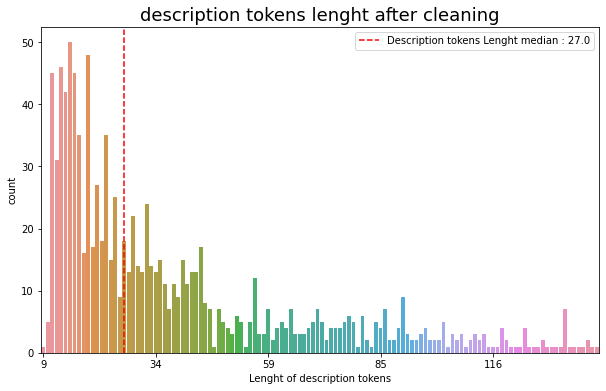

In [20]:
# Calculate lenght of each list in description
data['descrip_tokens_count'] = [len(_) for _ in data.description_cleaned]

# Countplot of body lenght
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data.descrip_tokens_count)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plot_median = data.descrip_tokens_count.median()
plt.axvline(plot_median - data.descrip_tokens_count.min(),
            color="r", linestyle='--',
            label="Description tokens Lenght median : "+str(plot_median))
ax.set_xlabel("Lenght of description tokens")
plt.title("description tokens lenght after cleaning",
          fontsize=18)
plt.legend()
plt.show()

Nous allons également regarder les fréquences de chaque mots de la variable description pour visualiser les plus représentés :

In [21]:
# Create a corpus of all tokens for description and product_name
corpus_descrp = []
for k in data['description_cleaned']:
    corpus_descrp.extend(k)
corpus_pname = []
for k in data['pname_cleaned']:
    corpus_pname.extend(k)

In [22]:
# Calculate distribition of words in description and products token list
descrp_dist = nltk.FreqDist(corpus_descrp)
pname_dist = nltk.FreqDist(corpus_pname)
descrp_dist_df = pd.DataFrame(descrp_dist.most_common(20),
                         columns=['Word', 'Frequency'])
pname_dist_df = pd.DataFrame(pname_dist.most_common(20),
                         columns=['Word', 'Frequency'])


Text(0.5, 1.0, '20 most frequent words on product name')

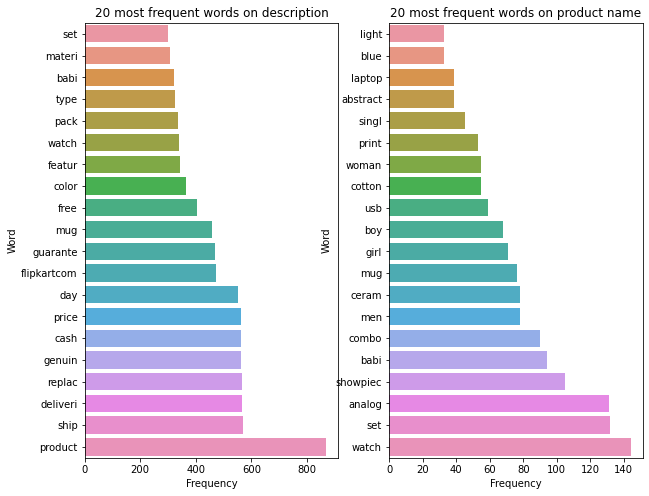

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

sns.barplot(data = descrp_dist_df.sort_values('Frequency'), x = 'Frequency',
           y = 'Word', ax = ax[0])
ax[0].set_title('20 most frequent words on description')

sns.barplot(data = pname_dist_df.sort_values('Frequency'), x = 'Frequency',
            y = 'Word', ax = ax[1])
ax[1].set_title('20 most frequent words on product name')

On constate des mots frequents dans les description qui n'apportent aucune precision sur le produit, on va donc les supprimer

In [24]:
words_to_keep = ['watch', 'baby', 'mug', 'cotton', 'girl', 'price',
                       'care', 'analog', 'showpiece', 'men', 'design', 'home',
                       'usb', 'laptop', 'boy', 'dial',
                       'woman', 'water', 'ceramic', 'battery']
temp = pd.DataFrame(descrp_dist.most_common(30),
                         columns=['Word', 'Frequency']).sort_values('Frequency',
                                                                    ascending = False)
common_words = list(temp['Word'].values)
for w in words_to_keep:
    if w in common_words :
        common_words.remove(w)

print(common_words)        
data['description_cleaned'] = data.description_cleaned\
    .apply(lambda x : [word for word in x
                       if word not in common_words])
                       

['product', 'ship', 'deliveri', 'replac', 'genuin', 'cash', 'day', 'flipkartcom', 'guarante', 'free', 'color', 'featur', 'pack', 'type', 'babi', 'materi', 'set', 'box', 'general', 'packag', 'specif', 'sale', 'print', 'number']


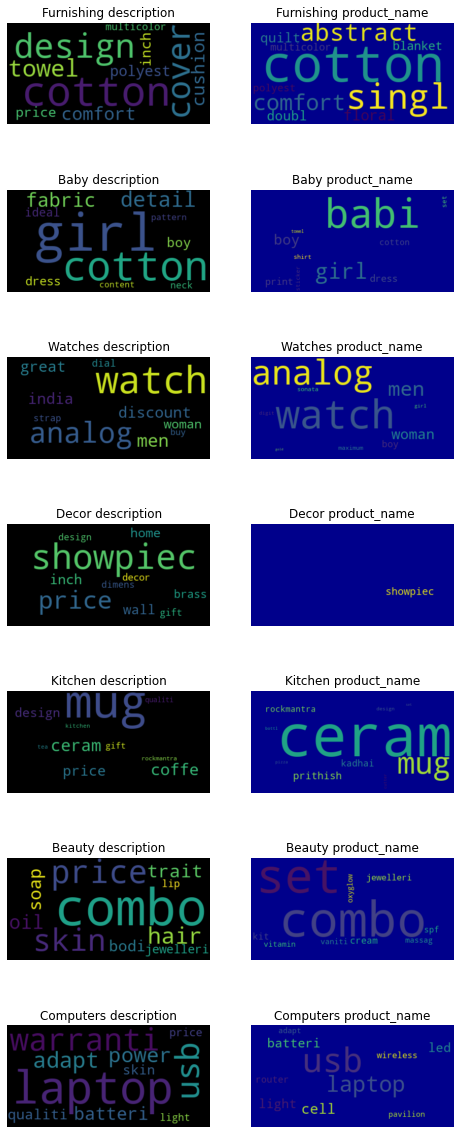

In [25]:
# Wordcloud of description and product_name by categories
plt.figure(figsize = (8,21))
category = list(data['cat_lvl_1'].unique())
for k in range(len(category)) :
    temp = data[data['cat_lvl_1'] == category[k]][['pname_cleaned','description_cleaned']].copy()
    corpus_descrp = []
    for i in temp['description_cleaned']:
        corpus_descrp.extend(i)
    corpus_pname = []
    for j in temp['pname_cleaned']:
        corpus_pname.extend(j)
    descrp_dist = nltk.FreqDist(corpus_descrp)
    pname_dist = nltk.FreqDist(corpus_pname)
    descrp_dist = pd.DataFrame(descrp_dist.most_common(10),
                         columns=['Word', 'Frequency'])
    pname_dist = pd.DataFrame(pname_dist.most_common(10),
                         columns=['Word', 'Frequency'])
    wc_descrp = WordCloud(background_color="black",
                      max_words=10, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(descrp_dist.set_index('Word').to_dict()['Frequency'])
    wc_pname = WordCloud(background_color="darkblue",
                      max_words=10, relative_scaling=1)\
    .generate_from_frequencies(pname_dist.set_index('Word').to_dict()['Frequency'])
    
    plt.subplot(7,2,2*k+1)
    plt.imshow(wc_descrp, interpolation='bilinear')
    plt.axis("off")
    plt.title(category[k]+' description')
    plt.subplot(7,2,2*k+2)
    plt.imshow(wc_pname, interpolation='bilinear')
    plt.axis("off")
    plt.title(category[k]+' product_name')
    

Regardons quelle est la frequence des mots dans le nomm de produit de la categorie Decor

In [26]:
temp = data[data['cat_lvl_1'] == 'Decor'][['pname_cleaned','description_cleaned']].copy()
corpus_pname = []
for j in temp['pname_cleaned']:
    corpus_pname.extend(j)
pname_dist = nltk.FreqDist(corpus_pname)
    
pname_dist = pd.DataFrame(pname_dist.most_common(10),
                         columns=['Word', 'Frequency'])
pname_dist

,Word,Frequency
0,showpiec,104
1,wall,15
2,inch,11
3,lal,10
4,have,10
5,decor,10
6,rice,10
7,light,10
8,handicraft,9
9,wooden,8


Nous avons donc un dataset cleane. On va ajouter une colonne regroupant le nom de produit et la description

In [27]:
temp = data[['uniq_id','cat_lvl_1', 'pname_cleaned','description_cleaned']].copy()
temp = temp.rename(columns={'cat_lvl_1':'category',
                         'pname_cleaned':'pname',
                         'description_cleaned': 'descrip'})

temp['name+descrip'] = temp['pname'] + temp['descrip']
data = temp.copy()


In [28]:
data.head(3)

,uniq_id,category,pname,descrip,name+descrip
0,55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,"[eleg, polyest, multicolor, abstract, eyelet, ...","[key, eleg, polyest, multicolor, abstract, eye...","[eleg, polyest, multicolor, abstract, eyelet, ..."
1,7b72c92c2f6c40268628ec5f14c6d590,Baby,"[sathiya, cotton, bath, towel]","[sathiya, cotton, bath, towel, bath, towel, re...","[sathiya, cotton, bath, towel, sathiya, cotton..."
2,64d5d4a258243731dc7bbb1eef49ad74,Baby,"[eurospa, cotton, terri, face, towel, set]","[key, eurospa, cotton, terri, face, towel, siz...","[eurospa, cotton, terri, face, towel, set, key..."


### 2 Clustering

Bien que les categories soient connues et donc qu'il soit plus naturel de faire une classification avec les algorithmes supervises habituels, il est precise en gras dans l'enonce que ce n'est pas ce qui est demande. 

Nous allons donc tenter divers clustering comme LDA, NMF ou encore KMeans.  

Pour alimenter les modèles de machine learning, nous avons besoin de traiter des données numériques. Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.  

Nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer. Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). Dans cette partie, nous allons éliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).

La métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

**2.1 Modèle LDA**

LDA, ou Latent Dirichlet Analysis est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité : P(word|topics)
et P(topics|documents)

. Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

2.1.1 LDA with BOW

In [29]:
#create dictionnary
dictionary_pname = gensim.corpora.Dictionary(data['pname'])
dictionary_desc = gensim.corpora.Dictionary(data['descrip'])
dictionary_tot = gensim.corpora.Dictionary(data['name+descrip'])

#filter
dictionary_pname.filter_extremes(no_below=1, no_above=0.6, keep_n=None)
dictionary_desc.filter_extremes(no_below=1, no_above=0.6, keep_n=None)
dictionary_tot.filter_extremes(no_below=1, no_above=0.6, keep_n=None)

# corpus
bow_corpus_pname = [dictionary_pname.doc2bow(doc) for doc in data['pname']]
bow_corpus_desc = [dictionary_desc.doc2bow(doc) for doc in data['descrip']]
bow_corpus_tot = [dictionary_tot.doc2bow(doc) for doc in data['descrip']]
print(bow_corpus_pname[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (6,1) ci-dessus indique que word_id 6 apparaît 1 fois dans le document et ainsi de suite.
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 60% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire. 

In [30]:
#LDA on pname, descrip and name+descrip
lda_model_pname = gensim.models.LdaMulticore(bow_corpus_pname,
                                             num_topics=7,
                                             id2word=dictionary_pname,
                                             passes=2, workers=4)
lda_model_desc = gensim.models.LdaMulticore(bow_corpus_desc,
                                             num_topics=7,
                                             id2word=dictionary_desc,
                                             passes=2, workers=4)
lda_model_tot = gensim.models.LdaMulticore(bow_corpus_tot,
                                             num_topics=7,
                                             id2word=dictionary_tot,
                                             passes=2, workers=4)


Visualisons les sujets trouves et les mots s'y rapportant

In [31]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
display(HTML("<style>.output_area { max-width:90% !important; }</style>"))
display(HTML("<style>.input_area { max-width:90% !important; }</style>"))

gensimvis.prepare(lda_model_pname, bow_corpus_pname, dictionary_pname)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.132147  0.000649       1        1  18.236359
2      0.085652 -0.105503       2        1  16.092461
6     -0.098616  0.083546       3        1  15.566568
4     -0.134122 -0.058930       4        1  14.068871
3     -0.044329 -0.091835       5        1  13.134832
5      0.014740  0.082145       6        1  12.990170
1      0.044527  0.089927       7        1   9.910739, topic_info=       Term        Freq       Total Category  logprob  loglift
91    ceram   57.000000   57.000000  Default  30.0000  30.0000
140     usb   45.000000   45.000000  Default  29.0000  29.0000
125     mug   56.000000   56.000000  Default  28.0000  28.0000
25    watch  117.000000  117.000000  Default  27.0000  27.0000
27      men   64.000000   64.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
25    watch    5.937538  117.191668   Topic7  -4.5550  -0.6710
13      set    5.680209  103.950007   Topic7  -4.5993  -0.5954
18    print    4.378152   43.601557   Topic7  -4.8597   0.0131
21   analog    5.226817  106.218160   Topic7  -4.6825  -0.7001
45    woman    4.133069   44.245159   Topic7  -4.9173  -0.0592

[410 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.191580  abstract
0         3  0.255440  abstract
0         4  0.223510  abstract
0         5  0.159650  abstract
0         6  0.127720  abstract
...     ...       ...       ...
45        7  0.090405     woman
724       4  0.760909   yardley
771       1  0.823504      york
922       1  0.818414      yuva
731       7  0.669635     zyxel

[718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 7, 5, 4, 6, 2])

On constate un melange des mots suivant les sujets proposes. 

In [32]:
gensimvis.prepare(lda_model_desc, bow_corpus_desc, dictionary_desc)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.141933 -0.071196       1        1  20.886862
2     -0.070545  0.151505       2        1  17.275896
1      0.053752 -0.010705       3        1  14.959796
0      0.123496  0.069347       4        1  13.411204
6     -0.072203 -0.084849       5        1  12.349578
5     -0.133877 -0.047914       6        1  10.972561
4     -0.042556 -0.006188       7        1  10.144104, topic_info=         Term        Freq       Total Category  logprob  loglift
440       mug  392.000000  392.000000  Default  30.0000  30.0000
82       skin  161.000000  161.000000  Default  29.0000  29.0000
128     watch  314.000000  314.000000  Default  28.0000  28.0000
62      towel  102.000000  102.000000  Default  27.0000  27.0000
1660   laptop  210.000000  210.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
410    detail   20.668699  222.682716   Topic7  -5.0439  -0.0889
183     round   16.027831   90.911797   Topic7  -5.2981   0.5527
279   pattern   15.949358  110.562891   Topic7  -5.3031   0.3521
28      model   16.526694  200.833934   Topic7  -5.2675  -0.2092
53      ideal   15.168593  132.669235   Topic7  -5.3532   0.1196

[545 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2068      3  0.176313    aari
2068      7  0.705250    aari
67        1  0.086671  absorb
67        2  0.780037  absorb
67        7  0.086671  absorb
...     ...       ...     ...
90        4  0.271245    year
90        5  0.018083    year
90        6  0.072332    year
90        7  0.072332    year
3081      6  0.650704    zora

[1457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 7, 6, 5])

La encore les topics ne sont pas clairement definis.

In [33]:
gensimvis.prepare(lda_model_tot, bow_corpus_tot, dictionary_tot)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.026929  0.092862       1        1  17.473967
2     -0.117002  0.101160       2        1  15.669406
6     -0.018108  0.029084       3        1  15.636481
1     -0.048048 -0.166129       4        1  13.919610
0     -0.079950  0.028144       5        1  12.981951
5      0.221679  0.025891       6        1  12.375464
4      0.014499 -0.111012       7        1  11.943122, topic_info=         Term        Freq       Total Category  logprob  loglift
444       mug  415.000000  415.000000  Default  30.0000  30.0000
130     watch  325.000000  325.000000  Default  29.0000  29.0000
123    analog  250.000000  250.000000  Default  28.0000  28.0000
1669   laptop  213.000000  213.000000  Default  27.0000  27.0000
57        men  168.000000  168.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
32       name   18.211515   95.326134   Topic7  -5.3337   0.4698
8     content   19.700426  142.285757   Topic7  -5.2551   0.1478
49        boy   17.284337  171.039047   Topic7  -5.3859  -0.1671
10     design   17.401272  268.581890   Topic7  -5.3792  -0.6116
53      ideal   16.369020  132.327810   Topic7  -5.4403   0.0351

[497 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.119646  abstract
0         2  0.215362  abstract
0         3  0.095716  abstract
0         4  0.023929  abstract
0         5  0.502511  abstract
...     ...       ...       ...
91        4  0.049162      year
91        5  0.032775      year
91        6  0.032775      year
91        7  0.081937      year
3093      7  0.680967      zora

[1398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 7, 2, 1, 6, 5])

In [34]:
df1 = fct.perplex_coherence(lda_model_pname,
                  bow_corpus_pname,
                  data['pname'],
                  dictionary_pname,
                 'lda_pname_bow')
df2 = fct.perplex_coherence(lda_model_desc,
                  bow_corpus_desc,
                  data['descrip'],
                  dictionary_desc,
                  'lda_desc_bow')
df3 = fct.perplex_coherence(lda_model_tot,
                  bow_corpus_tot,
                  data['name+descrip'],
                  dictionary_tot,
                  'lda_tot_bow')
comparaison1 = pd.concat([df1, df2], axis=1)
comparaison1 = pd.concat([comparaison1, df3], axis=1)
comparaison1

,lda_pname_bow,lda_desc_bow,lda_tot_bow
Perplexity,-7.01,-6.735,-6.645
Coherence,0.52,0.335,0.499


2.1.2 LDA with TF_IDF

In [35]:
tfidf_pname = gensim.models.TfidfModel(bow_corpus_pname)
corpus_pname_tfidf = tfidf_pname[bow_corpus_pname]
tfidf_desc = gensim.models.TfidfModel(bow_corpus_desc)
corpus_desc_tfidf = tfidf_desc[bow_corpus_desc]
tfidf_tot = gensim.models.TfidfModel(bow_corpus_tot)
corpus_tot_tfidf = tfidf_tot[bow_corpus_tot]


lda_model_pname_tfidf = gensim.models.LdaMulticore(corpus_pname_tfidf,
                                                   num_topics=7, 
                                                   id2word=dictionary_pname,
                                                   passes=2, workers=4)
lda_model_desc_tfidf = gensim.models.LdaMulticore(corpus_desc_tfidf,
                                                   num_topics=7, 
                                                   id2word=dictionary_desc,
                                                   passes=2, workers=4)
lda_model_tot_tfidf = gensim.models.LdaMulticore(corpus_tot_tfidf,
                                                   num_topics=7, 
                                                   id2word=dictionary_tot,
                                                   passes=2, workers=4)

Visualisations des resultats sur les topics obtenus

In [36]:
gensimvis.prepare(lda_model_pname_tfidf, corpus_pname_tfidf, dictionary_pname)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.107814 -0.033821       1        1  17.113065
3      0.029048 -0.100336       2        1  15.786198
5     -0.030117  0.062703       3        1  15.212243
6      0.044647 -0.000839       4        1  13.656614
1     -0.000145  0.035228       5        1  13.388091
0      0.053833  0.018671       6        1  12.936791
2      0.010549  0.018395       7        1  11.906998, topic_info=       Term       Freq      Total Category  logprob  loglift
917  sonata  10.000000  10.000000  Default  30.0000  30.0000
534  kadhai   7.000000   7.000000  Default  29.0000  29.0000
690   tenda   4.000000   4.000000  Default  28.0000  28.0000
10    towel   7.000000   7.000000  Default  27.0000  27.0000
91    ceram  15.000000  15.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
22      boy   1.145403  11.352634   Topic7  -5.4622  -0.1656
21   analog   1.295356  21.115922   Topic7  -5.3392  -0.6632
45    woman   1.140047  12.571845   Topic7  -5.4669  -0.2723
42     girl   1.085775  11.556962   Topic7  -5.5157  -0.2370
19   floral   0.954701   6.121963   Topic7  -5.6443   0.2698

[419 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.223397  abstract
0         2  0.335096  abstract
0         4  0.111699  abstract
0         5  0.111699  abstract
0         6  0.111699  abstract
...     ...       ...       ...
724       7  0.488108   yardley
187       2  0.386139    yellow
187       7  0.386139    yellow
771       3  0.813963      york
922       2  0.671976      yuva

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 7, 2, 1, 3])

Les topics ne sont toujours pas clairement determines

In [37]:
gensimvis.prepare(lda_model_desc_tfidf, corpus_desc_tfidf, dictionary_desc)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.013918  0.038276       1        1  17.082730
5      0.018971  0.039158       2        1  16.551531
6     -0.025108 -0.050873       3        1  14.568294
3      0.043400 -0.036198       4        1  14.328609
2      0.034955  0.003345       5        1  13.313737
0     -0.055710  0.000321       6        1  12.730101
1     -0.002589  0.005971       7        1  11.424998, topic_info=         Term       Freq      Total Category  logprob  loglift
440       mug  16.000000  16.000000  Default  30.0000  30.0000
434     coffe   6.000000   6.000000  Default  29.0000  29.0000
1628  maximum   5.000000   5.000000  Default  28.0000  28.0000
62      towel   7.000000   7.000000  Default  27.0000  27.0000
1494    tenda   3.000000   3.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
9     curtain   0.767459   3.720302   Topic7  -6.1759   0.5909
18     floral   0.784028   4.440648   Topic7  -6.1545   0.4353
54       inch   0.809441   6.254055   Topic7  -6.1226   0.1247
92      cover   0.751286   4.721418   Topic7  -6.1972   0.3313
128     watch   0.754012  18.220666   Topic7  -6.1935  -1.0155

[438 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.148207  abstract
0         2  0.148207  abstract
0         3  0.148207  abstract
0         4  0.148207  abstract
0         6  0.444621  abstract
...     ...       ...       ...
1520      7  0.523593   yardley
90        1  0.516198      year
90        4  0.258099      year
1960      5  0.880458      yuva
1526      3  0.629089     zyxel

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 4, 3, 1, 2])

Chevauchement des mots sur differents topics

In [38]:
gensimvis.prepare(lda_model_tot_tfidf, corpus_tot_tfidf, dictionary_tot)

C:\Users\leila\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.040695  0.056771       1        1  19.440755
1      0.059109 -0.014931       2        1  17.393806
6      0.007448 -0.065094       3        1  13.939194
2     -0.035224 -0.001065       4        1  13.455264
3     -0.002583  0.011168       5        1  13.438644
4     -0.048122  0.025044       6        1  11.746965
0     -0.021325 -0.011893       7        1  10.585371, topic_info=         Term       Freq      Total Category  logprob  loglift
444       mug  16.000000  16.000000  Default  30.0000  30.0000
438     coffe   6.000000   6.000000  Default  29.0000  29.0000
62      towel   7.000000   7.000000  Default  28.0000  28.0000
1503    tenda   3.000000   3.000000  Default  27.0000  27.0000
2361  blanket   6.000000   6.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
584     bottl   0.726246   3.642664   Topic7  -6.1547   0.6331
50     cotton   0.860964   9.932612   Topic7  -5.9846  -0.1998
10     design   0.800907   8.182543   Topic7  -6.0569  -0.0783
132     onlin   0.754009   7.174813   Topic7  -6.1172  -0.0072
34      price   0.710221   6.590667   Topic7  -6.1770   0.0179

[429 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.146245  abstract
0         2  0.146245  abstract
0         4  0.438734  abstract
0         5  0.146245  abstract
0         6  0.146245  abstract
...     ...       ...       ...
91        2  0.504740      year
91        3  0.252370      year
1569      5  0.917704      york
1971      5  0.913233      yuva
1535      2  0.604451     zyxel

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 3, 4, 5, 1])

meme remarque que pour descrip

In [39]:
df4 = fct.perplex_coherence(lda_model_pname_tfidf,
                  corpus_pname_tfidf,
                  data['pname'],
                  dictionary_pname,
                  'lda_pname_tfidf')
df5 = fct.perplex_coherence(lda_model_desc_tfidf,
                  corpus_desc_tfidf,
                  data['descrip'],
                  dictionary_desc,
                  'lda_desc_tfidf')
df6 = fct.perplex_coherence(lda_model_tot_tfidf,
                  corpus_tot_tfidf,
                  data['name+descrip'],
                  dictionary_tot,
                 'lda_tot_tfidf')
comparaison2 = pd.concat([df4, df5], axis=1)
comparaison2 = pd.concat([comparaison2, df6], axis=1)
comparaison_lda = pd.concat([comparaison1, comparaison2], axis=1)
comparaison_lda

,lda_pname_bow,lda_desc_bow,lda_tot_bow,lda_pname_tfidf,lda_desc_tfidf,lda_tot_tfidf
Perplexity,-7.01,-6.735,-6.645,-8.840,-9.584,-9.553
Coherence,0.52,0.335,0.499,0.575,0.502,0.457


La coherence la plus forte est obtenue pour le model lda_tfidf sur pname. Visualisons comment sont representes les topics par rapport aux categories 

In [40]:
# Binarize the column catagory
y = data['category']
label_binarizer = LabelBinarizer()
label_binarizer.fit(y)
y_binarized = label_binarizer.transform(y)

In [41]:
# topic_category matrix
topic_cat_pname,pname_topic = fct.topic_cat_matrix(lda_model_pname_tfidf,
                                            corpus_pname_tfidf,
                                            y_binarized)

# results predicted topics
results_pname = fct.results(pname_topic,topic_cat_pname, y_binarized, data['category'])
# classification scores
scores_pname = fct.scores_aprf1(results_pname, 'lda_tfidf_pname')
scores_pname

C:\Users\leila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,lda_tfidf_pname
Test Accuracy,0.267619
Precision,0.186308
Recall,0.267619
F1_score,0.213075


**2.2 model NMF**

La factorisation matricielle non négative *(**N**on-negative **M**atrix **F**actorization)* est un modèle linéaire-algéabrique, qui factorise des vecteurs de grande dimension dans une représentation de faible dimension. Similaire à l'analyse en composantes principales *(PCA)*, NMF profite du fait que les vecteurs sont non négatifs. En les factorisant dans la forme de dimension inférieure, NMF force les coefficients à être également non négatifs.

Prenons une matrice d'origine $A$, nous pouvons obtenir deux matrices $W$ et $H$, telles que $A = WH$. NMF a une propriété de clustering, telle que $W$ et $H$ représentent les informations suivantes sur $A$ :
- $A$ (Matrice Document-word) : Matrice qui contient "quels mots apparaissent dans quels documents".
- $W$ (Vecteurs de base) : Topics découverts à partir des documents.
- $H$ (Matrice de coefficients) : les poids pour les topics dans chaque document.

Nous calculons W et H en optimisant sur une fonction objectif, en mettant à jour à la fois $W$ et $H$ de manière itérative jusqu'à convergence.

$$\frac{1}{2}||A−WH||_F^2=\sum\limits_{(i,j)} (A_{ij}−(WH)_{ij})^2$$
Dans cette fonction objectif, nous mesurons l'erreur de reconstruction entre $A$ et le produit de ses facteurs $W$ et $H$, en fonction de la distance euclidienne. Les valeurs mises à jour sont calculées dans des opérations parallèles, et en utilisant les nouveaux $W$ et $H$, nous recalculons l'erreur de reconstruction, en répétant ce processus jusqu'à la convergence. 

In [42]:
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

X_pname = data['pname']
X_desc = data['descrip']
X_tot = data['name+descrip']

X_pname_tfidf = vectorizer.fit_transform(X_pname)
X_desc_tfidf = vectorizer.fit_transform(X_desc)
X_tot_tfidf = vectorizer.fit_transform(X_tot)

# Initializing the NMF
nmf = NMF(n_components=7,
               init='nndsvd',
               random_state=8)

# Fit NMF on pname vectorized
nmf.fit(X_pname_tfidf)


NMF(init='nndsvd', n_components=7, random_state=8)

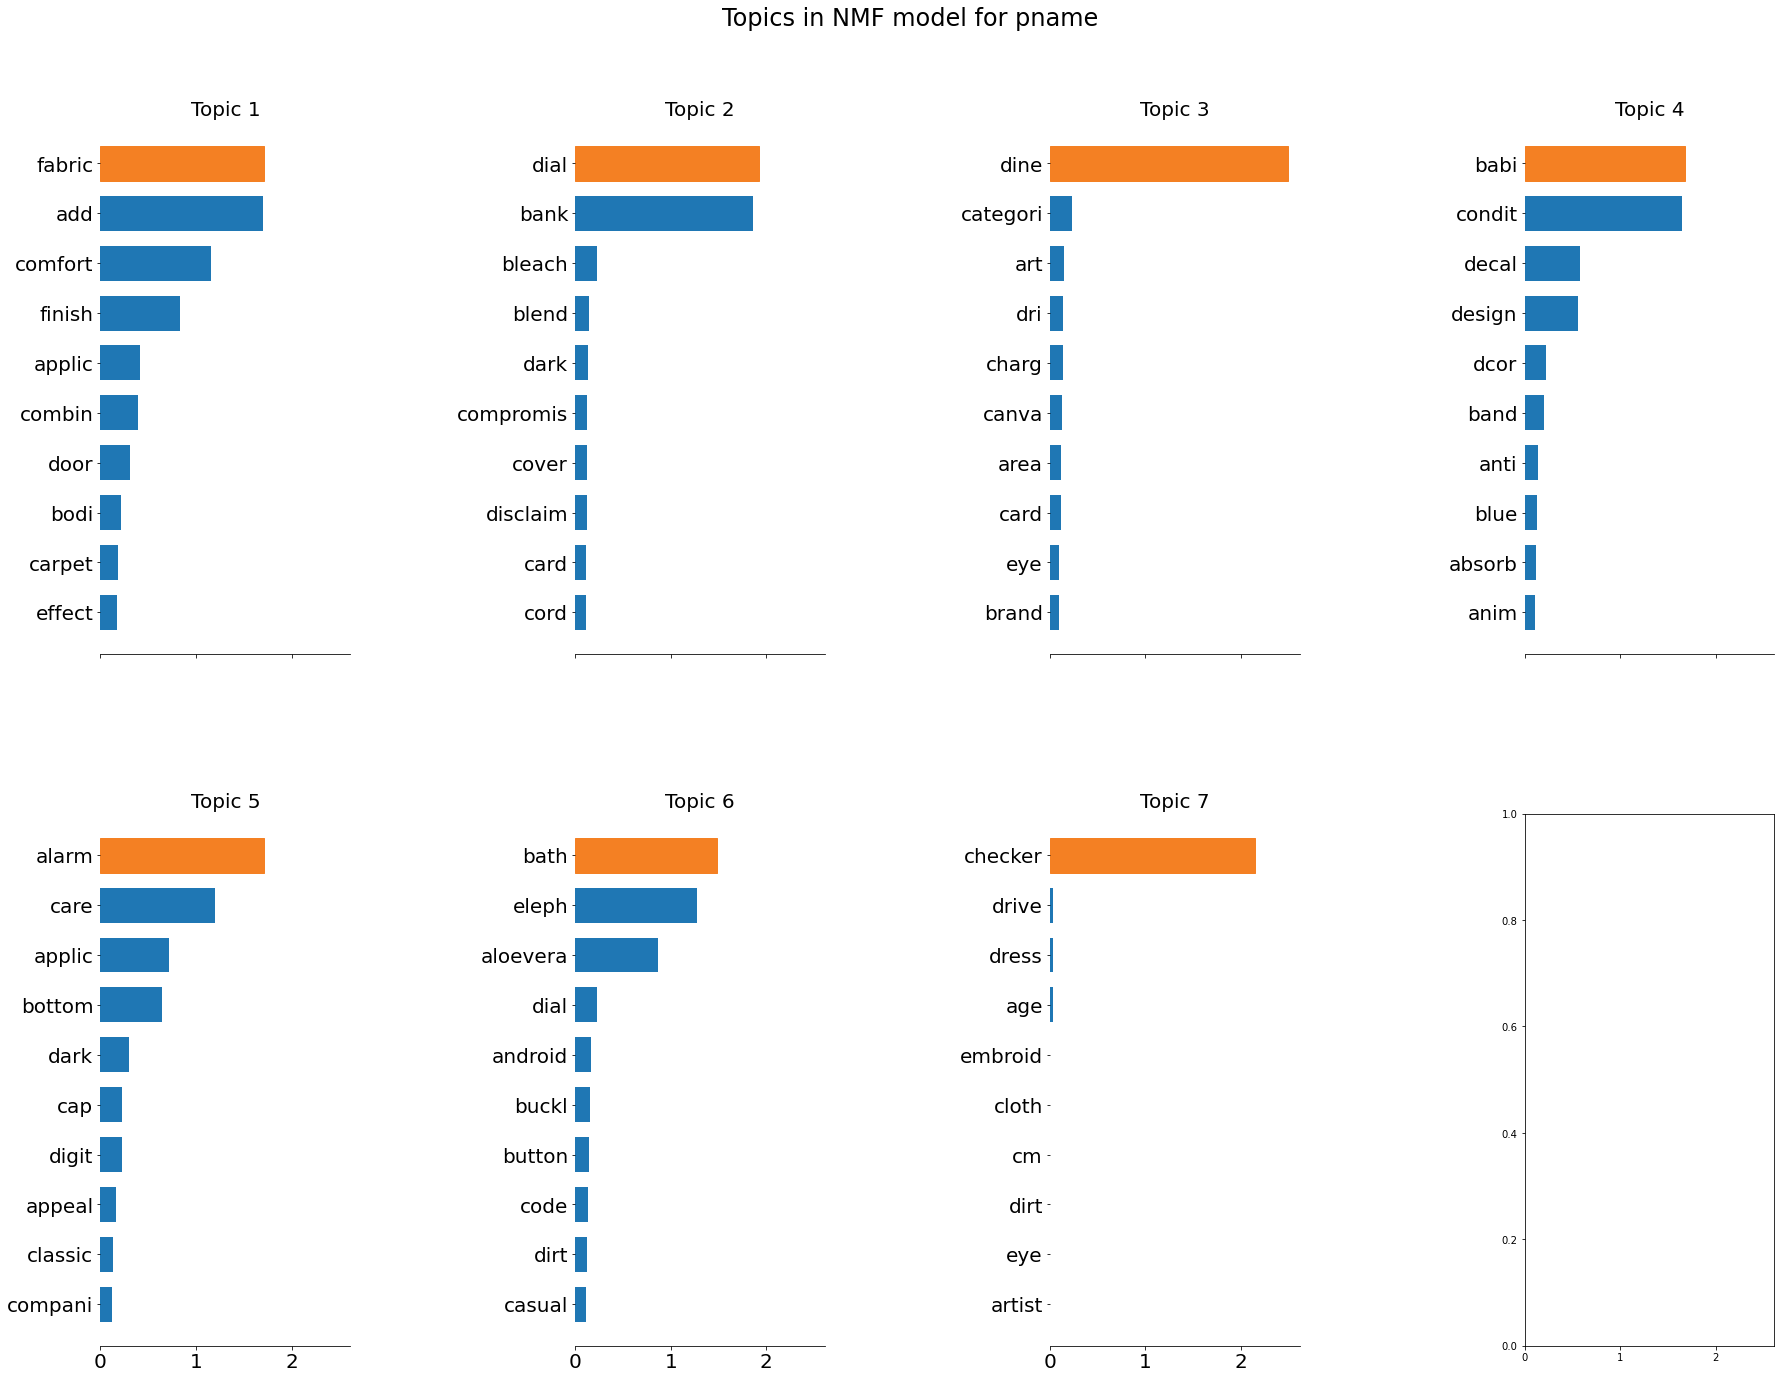

In [43]:
# visualisations
pname_feature_names = vectorizer.get_feature_names()
fct.plot_top_words(nmf, pname_feature_names, 10, 
               'Topics in NMF model for pname')

En regardant les mots de chaque topic, il ne me parait pas evident de retrouver les categories

In [44]:
# stock scores accuracy, precision, recall, f1
W_pname = nmf.transform(X_pname_tfidf)
doc_topic_pname = pd.DataFrame(W_pname)
topic_cat_pname = doc_topic_pname.T.dot(y_binarized)
pname_nmf_results = fct.results(doc_topic_pname, topic_cat_pname,
                                y_binarized, data['category'])
pname_nmf_scores = fct.scores_aprf1(pname_nmf_results, 'nmf_pname')

C:\Users\leila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


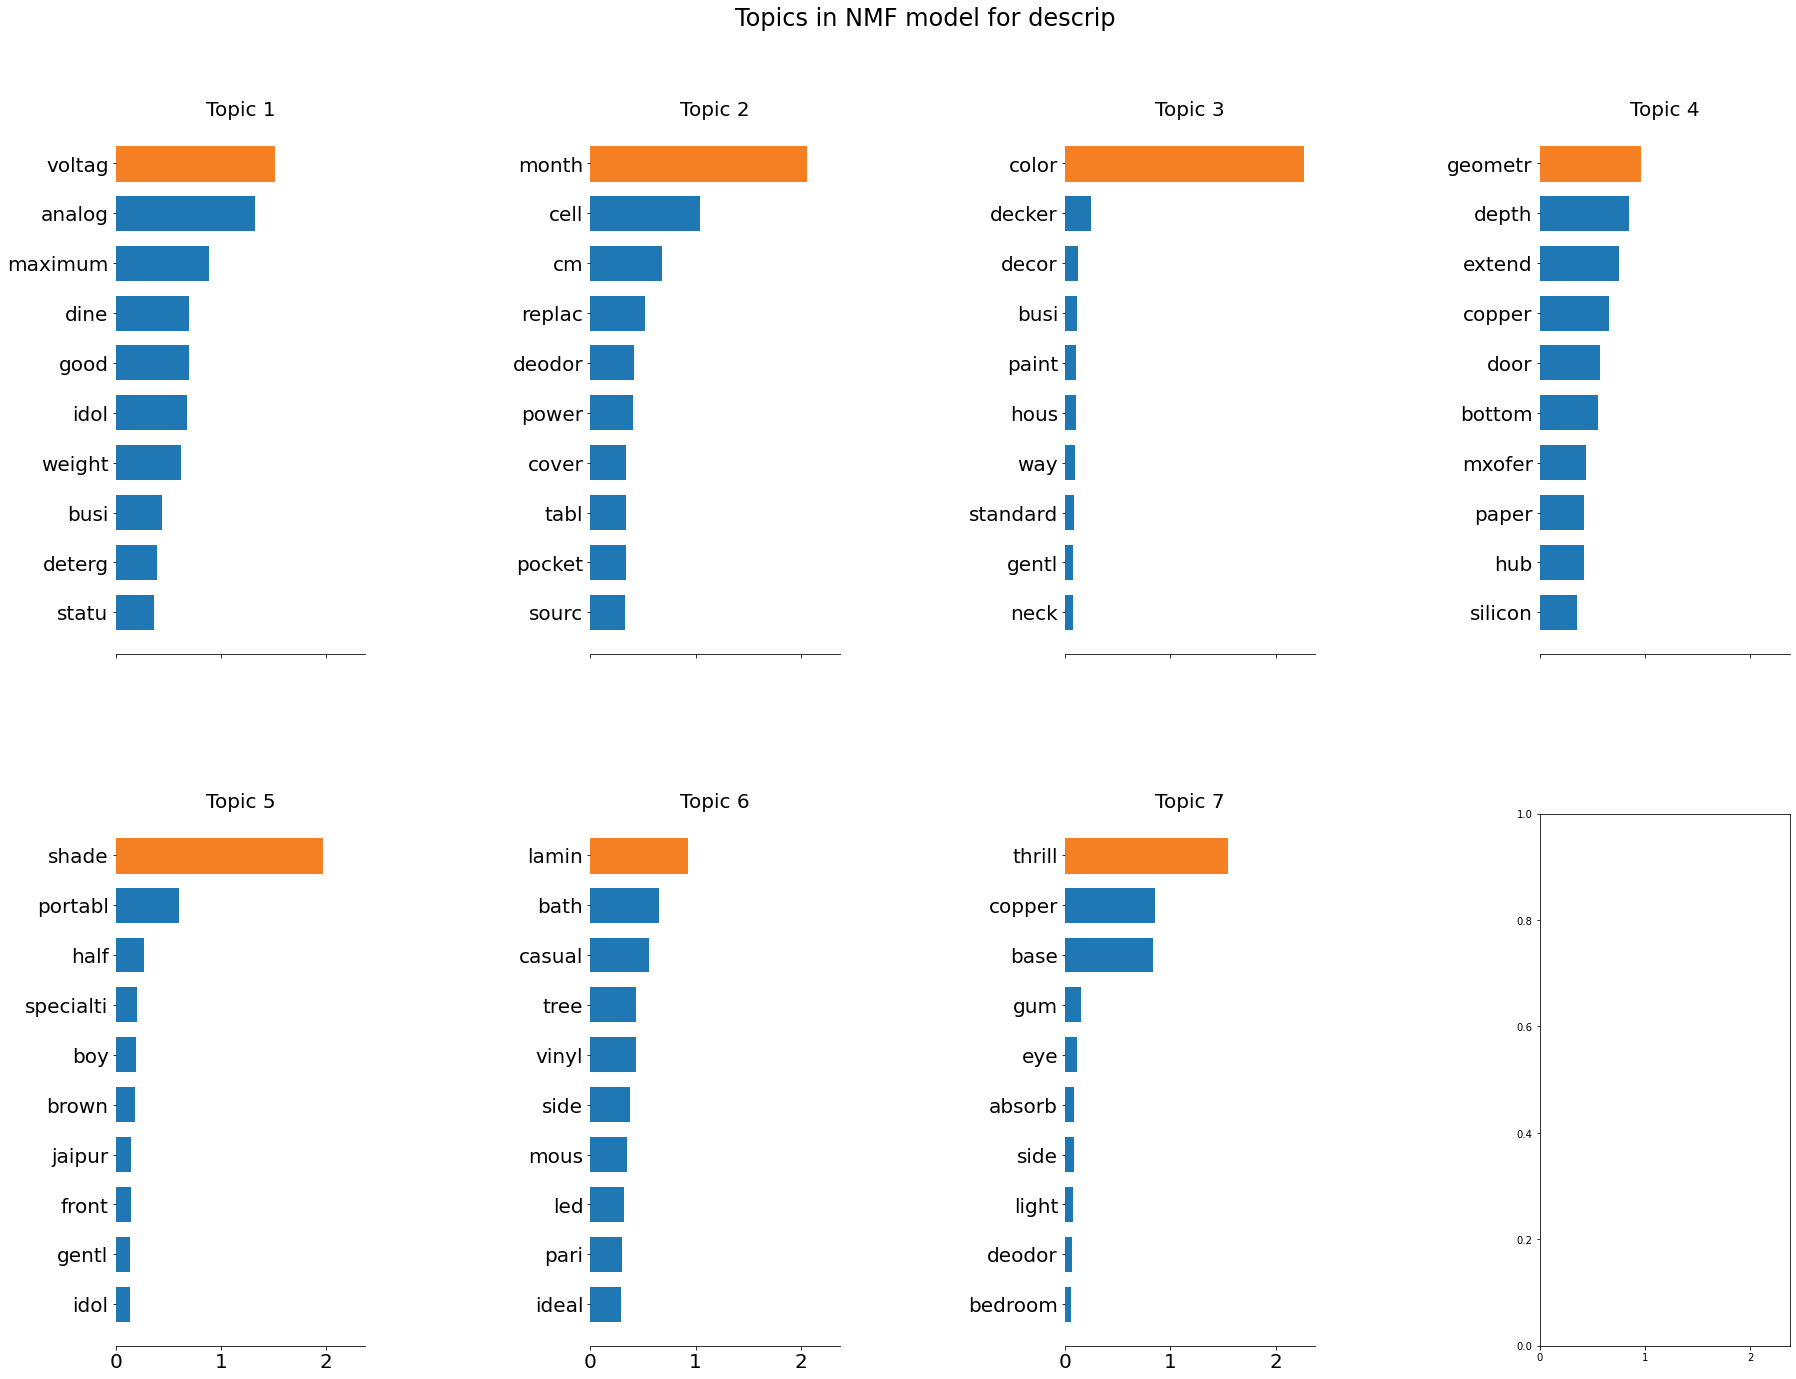

In [45]:
nmf.fit(X_desc_tfidf)
desc_feature_names = vectorizer.get_feature_names()
fct.plot_top_words(nmf, desc_feature_names, 10, 
               'Topics in NMF model for descrip')

meme probleme que pour pname

In [46]:
# stock scores accuracy, precision, recall, f1
W_desc = nmf.transform(X_desc_tfidf)
doc_topic_desc = pd.DataFrame(W_desc)
topic_cat_desc = doc_topic_desc.T.dot(y_binarized)
desc_nmf_results = fct.results(doc_topic_desc, topic_cat_desc, y_binarized, data['category'])
desc_nmf_scores = fct.scores_aprf1(desc_nmf_results, 'nmf_desc')

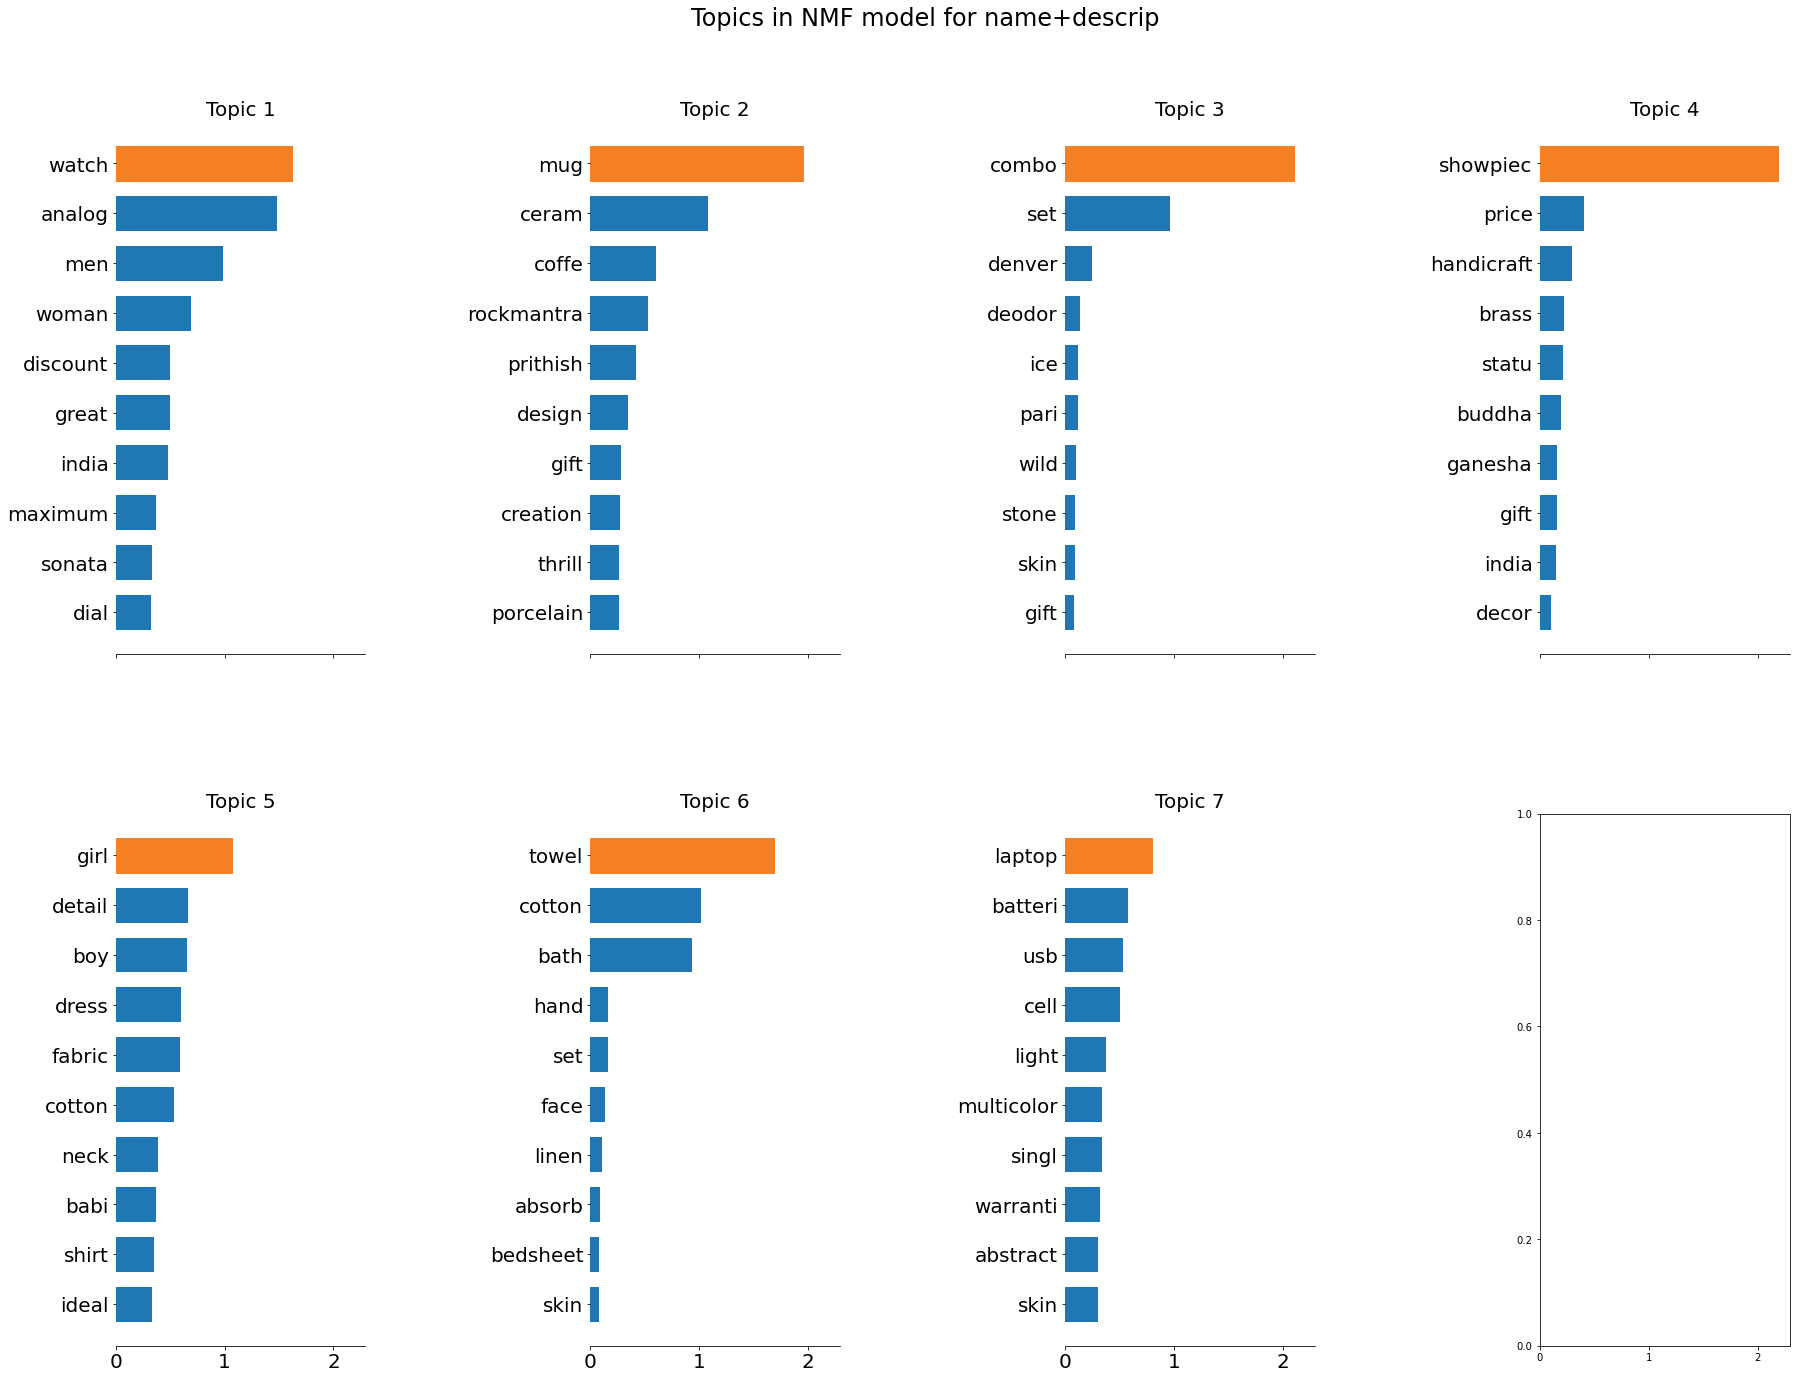

In [47]:
nmf.fit(X_tot_tfidf)
tot_feature_names = vectorizer.get_feature_names()
fct.plot_top_words(nmf, tot_feature_names, 10, 
               'Topics in NMF model for name+descrip')

Ici on retrouve beaucoup mieux les categories suivant les topics :
- Topic 1 : Watch
- Topic 2 : Kitchen
- Topic 3 : Beauty
- Topic 4 : Decor
- Topic 5 : Baby
- Topic 6 : Furnishing
- Topic 7 : computers

In [48]:
# stock scores accuracy, precision, recall, f1
W_tot = nmf.transform(X_tot_tfidf)
doc_topic_tot = pd.DataFrame(W_tot)
topic_cat_tot = doc_topic_tot.T.dot(y_binarized)
tot_nmf_results = fct.results(doc_topic_tot,topic_cat_tot, y_binarized, data['category'])
tot_nmf_scores = fct.scores_aprf1(tot_nmf_results, 'nmf_tot')

In [49]:
# compare score on nmf
compare_nmf = pd.concat([pname_nmf_scores, desc_nmf_scores], axis=1)
compare_nmf = pd.concat([compare_nmf, tot_nmf_scores], axis=1)
compare_nmf

,nmf_pname,nmf_desc,nmf_tot
Test Accuracy,0.643810,0.629524,0.631429
Precision,0.569138,0.736156,0.747425
Recall,0.643810,0.629524,0.631429
F1_score,0.594373,0.626802,0.638505


Il resulte de la comparaison des scores qu'a priori le meilleur clustering est avec name+descrip

In [50]:
def f(x):
    if x == 0:
        return 'Baby'
    elif x == 1:
        return 'Beauty'
    elif x == 2:
        return 'Computers'
    elif x == 3:
        return 'Decor'
    elif x == 4:
        return 'Furnishing'
    elif x == 5:
        return 'Kitchen'
    else:
        return 'Watches'
        

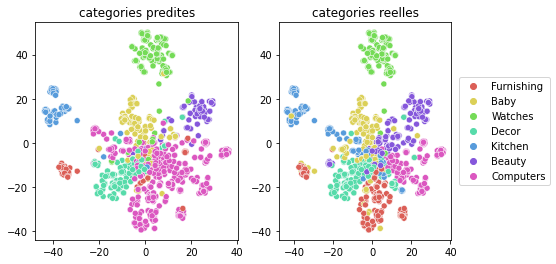

In [51]:
# representation des categories predites et reelles

tot_nmf_results['cat_pred'] = tot_nmf_results['y_pred'].apply(lambda x : f(x))
tot_nmf_labels = tot_nmf_results['cat_pred'].values
labels = tot_nmf_results['category'].values
colors1 = list(tot_nmf_results['category'].unique())
fct.plot_TSNE(X_tot_tfidf, tot_nmf_labels, labels, colors1,'nmf')

On remarque que la categorie Watches est bien trouvee. La categorie qui semble poser le plus de probleme est celle de Furnishing et de Computers.

**2.3 KMeans**

Avant d'utiliser directement KMeans, nous allons regarder si l'on peut diminuer les dimention des donnees vectorisees.  
On se propose pour cela d'utiliser TruncatedSVD.  

La decomposition en valeurs singulieres existe pour toute matrice $M$ reelle ou complexe :
$$M = U\Sigma V^{*}$$
- $V$ contient un ensemble de vecteurs de base orthonormés de Kn, dits « d'entrée » ou « d'analyse » ;
- $U$ contient un ensemble de vecteurs de base orthonormés de Km, dits « de sortie » ;
- $\Sigma$ contient dans ses coefficients diagonaux les valeurs singulières de la matrice $M$, elles correspondent aux racines des valeurs propres de $ M^{*}M$.  
Une convention courante est de ranger les valeurs $\Sigma_{ii}$ par ordre decroissant. Alors, la matrice $\Sigma$ est déterminee de façon unique par $M$ (mais $U$ et $V$ ne le sont pas).

Cette decomposition est efficace en particulier pour les matrices clairsemees, ce qui est notre cas ici.

La premiere etape, comme pour PCA, est de determiner le nombre de dimensions donc de valeurs propres que l'on va garder

In [52]:
print('dimension de X_pname_tfidf : ', X_pname_tfidf.shape)
print('dimension de X_desc_tfidf : ', X_desc_tfidf.shape)
print('dimension de X_tot_tfidf : ', X_tot_tfidf.shape)

dimension de X_pname_tfidf :  (1050, 199)
dimension de X_desc_tfidf :  (1050, 569)
dimension de X_tot_tfidf :  (1050, 577)


Variance cumulee suivant le nombre de features 

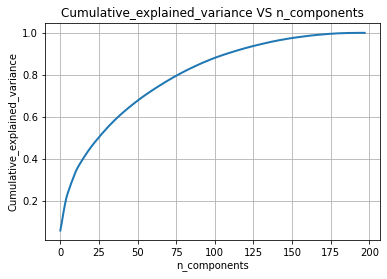

In [53]:
fct.plotCumulativeVariance(X_pname_tfidf)

On va donc garder 150 features au lieu de 199 pour pname

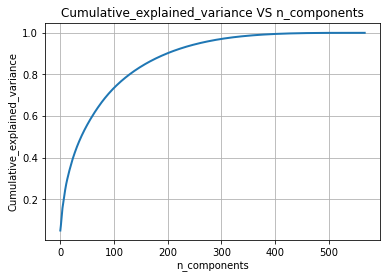

In [54]:
fct.plotCumulativeVariance(X_desc_tfidf)

On garde 300 features au lieu de 569 pour descrip

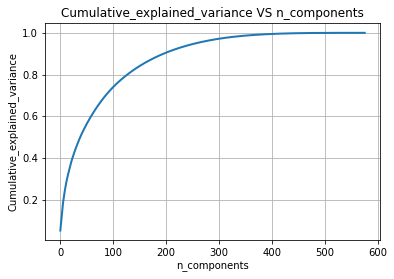

In [55]:
fct.plotCumulativeVariance(X_tot_tfidf)

Egalement 300 features au lieu de 577 pour name + descrip

In [56]:
# project for pname, desc et tot
X_pname_t = fct.computeVectors(X_pname_tfidf, 150)
X_desc_t = fct.computeVectors(X_desc_tfidf, 300)
X_tot_t = fct.computeVectors(X_tot_tfidf, 300)

On peut maintenant utiliser KMeans sur les donnees projetees et regarder les scores

In [57]:
labels_true = data['category'].values
km = KMeans(n_clusters=7)

# pname
km.fit(X_pname_t)
labels_pname = km.labels_
pname_km_scores = fct.clusters_scores(labels_pname, labels_true, 'pname_km')

# descrip
km.fit(X_desc_t)
labels_desc = km.labels_
desc_km_scores = fct.clusters_scores(labels_desc, labels_true, 'desc_km')

# name+descrip
km.fit(X_tot_t)
labels_tot = km.labels_
tot_km_scores = fct.clusters_scores(labels_tot, labels_true, 'tot_km')

# compare scores
compare_km = pd.concat([pname_km_scores, desc_km_scores], axis=1)
compare_km = pd.concat([compare_km, tot_km_scores], axis=1)
compare_km

,pname_km,desc_km,tot_km
Homogeneity,0.624292,0.628024,0.628425
Completeness,0.521258,0.491077,0.540508
V_measure,0.568142,0.551171,0.581160
ARI,0.298946,0.259782,0.301115


Les resultats sont globalement meilleurs sur nama+descrip, la encore.

In [58]:
# translate clusters in categories
temp = data[['category']].copy()
temp['labels_tot'] = labels_tot
tab = temp.pivot_table(index='labels_tot', columns='category',aggfunc=len)
tab.fillna(0,inplace=True)
l = tab.to_numpy().argmax(axis=1)
temp['cat_pred_num']=temp['labels_tot'].apply(lambda x : l[x])
temp.head()

,category,labels_tot,cat_pred_num
0,Furnishing,0,4
1,Baby,2,0
2,Baby,2,0
3,Furnishing,0,4
4,Furnishing,0,4


In [59]:
temp['cat_pred'] = temp['cat_pred_num'].apply(lambda x: f(x))
cat_pred = list(temp['cat_pred'].values)

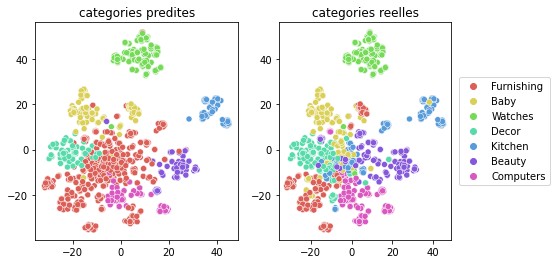

In [60]:
#representation via TSNE
cat_pred = temp['cat_pred'].values
fct.plot_TSNE(X_tot_t, cat_pred, labels_true, colors1, 'KMeans')


Conclusion : les methodes trouvees ne sont pas efficaces. Regardons ce que donne une classification, ce qui permettra de conclure si on peut automatiser ce qui va etre trouve.


### 3 Classification

Les methodes utilisees sont les memes que dans les precedents projets et donc sont moins detailles. Le principe est de faire une recherche des meilleurs parametres suivant les scores obtenus et d'en deduire le modele le plus efficace pour le probleme pose.

In [61]:
# Define Z and y
Z= data[['pname',"descrip", 'name+descrip']]
y = data["category"]

In [62]:
# Create train and test split (25%)
Z_train, Z_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.25, random_state=8)
print("Z_train shape : {}".format(Z_train.shape))
print("Z_test shape : {}".format(Z_test.shape))


Z_train shape : (787, 3)
Z_test shape : (263, 3)


In [63]:
NGRAM_RANGE = (1,2)
def ngram_vectorize(train_texts, train_labels, val_texts):
    # vectorizer with max_df = 60 %
    verctorizer = TfidfVectorizer(ngram_range = NGRAM_RANGE, max_df=0.6)
    x_train = vectorizer.fit_transform(train_texts)
    x_val = vectorizer.transform(val_texts)
    
    # select top k of the vectorized features
    selector = SelectKBest(f_classif, k = min(500, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Xpn_train = Z_train['pname']
Xpn_test = Z_test['pname']
Xd_train = Z_train['descrip']
Xd_test = Z_test['descrip']
Xtot_train = Z_train['name+descrip']
Xtot_test = Z_test['name+descrip']

xpn_train,xpn_val = ngram_vectorize(Xpn_train, y_train, Xpn_test)
xd_train,xd_val = ngram_vectorize(Xd_train, y_train, Xd_test)
xtot_train,xtot_val = ngram_vectorize(Xtot_train, y_train, Xtot_test)

In [64]:
#list models
models_B = list([fct.rfc([25, 50, 75]),
                 fct.knn([3, 5, 7, 9], ['uniform', 'distance']),
                 fct.svc(['l1', 'l2'], ['squared_hinge']),
                 fct.lr([2,5,10]),
                 fct.multinb([0,0.5,1])])



In [65]:
results_B_pn = fct.model_benchmark(xpn_train, y_train, xpn_val, y_test, models_B)
results_B_d = fct.model_benchmark(xd_train, y_train, xd_val, y_test, models_B)
results_B_tot = fct.model_benchmark(xtot_train, y_train, xtot_val, y_test, models_B)

In [66]:
results_B_pn['perf']

,multinb,lr,svc,knn,rfc
Test Accuracy,0.867000,0.875000,0.871000,0.833000,0.878000
Precision,0.877220,0.886251,0.883224,0.867810,0.893047
Recall,0.870516,0.876720,0.873545,0.836636,0.881080
F1_score,0.865470,0.874422,0.870933,0.842723,0.879132


In [67]:
results_B_pn['perf'] = results_B_pn['perf'].rename(columns={'multinb': 'multinb_pn',
                                                           'lr': 'lr_pn',
                                                           'svc': 'svc_pn',
                                                           'knn': 'knn_pn',
                                                           'rfc' :'rfc_pn'})

results_B_d['perf'] = results_B_d['perf'].rename(columns={'multinb': 'multinb_d',
                                                           'lr': 'lr_d',
                                                           'svc': 'svc_d',
                                                           'knn': 'knn_d',
                                                           'rfc' :'rfc_d'})

results_B_tot['perf'] = results_B_tot['perf'].rename(columns={'multinb': 'multinb_tot',
                                                           'lr': 'lr_tot',
                                                           'svc': 'svc_tot',
                                                           'knn': 'knn_tot',
                                                           'rfc' :'rfc_tot'})

In [68]:
perf_b = pd.concat([results_B_pn['perf'], results_B_d['perf']],axis=1)
perf_b = pd.concat([perf_b, results_B_tot['perf']],axis=1)
perf_b

,multinb_pn,lr_pn,svc_pn,knn_pn,rfc_pn,multinb_d,lr_d,svc_d,knn_d,rfc_d,multinb_tot,lr_tot,svc_tot,knn_tot,rfc_tot
Test Accuracy,0.867000,0.875000,0.871000,0.833000,0.878000,0.890000,0.920000,0.932000,0.802000,0.920000,0.894000,0.913000,0.916000,0.848000,0.924000
Precision,0.877220,0.886251,0.883224,0.867810,0.893047,0.891185,0.920467,0.931064,0.850191,0.922410,0.894926,0.913482,0.915667,0.880106,0.927988
Recall,0.870516,0.876720,0.873545,0.836636,0.881080,0.893326,0.922281,0.933809,0.814038,0.924591,0.896058,0.914905,0.918080,0.856242,0.928533
F1_score,0.865470,0.874422,0.870933,0.842723,0.879132,0.889140,0.919689,0.931614,0.809425,0.921118,0.891873,0.911983,0.915205,0.853941,0.925687


Le gagnant est svc_d, donc le model svc avec la colonne description.

In [69]:
# best parameters
results_B_d['param']

[['rfc', {'n_estimators': 75}],
 ['knn', {'n_neighbors': 3, 'weights': 'distance'}],
 ['svc',
  {'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}],
 ['lr',
  {'C': 5,
   'class_weight': 'balanced',
   'multi_class': 'multinomial',
   'solver': 'lbfgs'}],
 ['multinb', {'alpha': 0.5}]]

Visualisations des predictions via tSNE

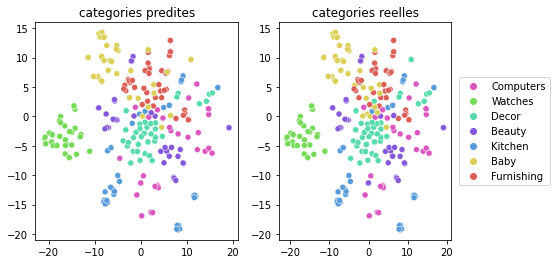

In [71]:
fct.plot_TSNE(xd_val, results_B_d['y_pred'][2][1], y_test, colors1, 'SVC')

In [87]:
data[['uniq_id','category','pname','name+descrip']].set_index('uniq_id').to_csv('pname_tot.csv')


pname_nmf_results.to_csv('pname_nmf.csv')
tot_nmf_results.to_csv('tot_nmf.csv')

doc_topic_tot.to_csv('topic_tot.csv')